In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold

In [2]:
data = pd.read_csv('../input/football-hackathon/train_1K0BDt5/train.csv')
test = pd.read_csv('../input/football-hackathon/test_kuhCxHY/test.csv')
sub  = pd.read_csv('../input/football-hackathon/sample_submission_wBWLI0s.csv')

### handling cat features

In [3]:
winner = {'winner': 1, 'loser': -1, 'draw': 0}

data['winner'] = data['winner'].map(winner)
test['winner'] = test['winner'].map(winner)

data['team'] = data['team'].map({'team1' : 0, 'team2' : 1})
test['team'] = test['team'].map({'team1' : 0, 'team2' : 1})

data = pd.get_dummies(data, columns = ['competitionId', 'scout_id','team1_system_id', 'team2_system_id', 'player_position_1','player_position_2'])
test = pd.get_dummies(test, columns = ['competitionId', 'scout_id','team1_system_id', 'team2_system_id', 'player_position_1','player_position_2'])

del data['row_id'], test['row_id']

In [4]:
cols = list(set(test.columns.to_list()).intersection(set(data.columns.to_list())))

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mean_squared_error',
    'num_iterations' : 4000,
    'learning_rate' : 0.05,
    'min_data_in_leaf' : 75,
    'num_leaves' : 71,
    'feature_fraction' : 0.5,
    'bagging_fraction' : 0.8,
    'bagging_freq' : 1,
    'lambda_l1' : 0.0,
    'lambda_l2' : 0.0,
    'nthread':-1,
    'seed' : 16,
}

# REmove NaN columns

remove_cols = []
for col in cols:
    
    if data[col].isna().sum() > 15000: remove_cols.append(col)
        
for col in remove_cols :
    cols.remove(col)
    
print(len(cols))

843


In [5]:
cols123 = cols

## Remove columns with low var

In [6]:
remove_cols = []
for col in cols123:
    
    if data[col].var() < 0.01 : remove_cols.append(col)
        
for col in remove_cols :
    cols.remove(col)
    
print(len(cols))

524


In [7]:
N_folds = 5
seeds = [652,784, 320]

data_preds = np.zeros((data.shape[0]))
test_preds = np.zeros((test.shape[0]))

feature_importance = pd.DataFrame()
fold_scores = []

for seed in seeds:
    print('---------------------------------------')
    print('SEED : ', seed)
    print('---------------------------------------')
    
    
    data['fold'] = -1
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True, random_state=seed)
    for f, (_, idxs) in enumerate(skf.split(data,data['rating_num'].apply(lambda x: int(2*x)))):
        data.loc[idxs, 'fold'] = f
        
    for F in range(N_folds):
        
        print('FOLD : ', F)
        
        train = data[data['fold'] != F].reset_index(drop=True)
        valid = data[data['fold'] == F].reset_index(drop=True)
        
        
        train_dataset = lgb.Dataset(train[cols], train['rating_num'])
        valid_dataset = lgb.Dataset(valid[cols], valid['rating_num'])
        
        model = lgb.train(params = lgb_params,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, valid_dataset], 
                          verbose_eval = 50,
                          early_stopping_rounds=50)
        
        del train_dataset, valid_dataset
        
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = cols
        fold_importance["importance"] = model.feature_importance()
        fold_importance["fold"] = F + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
        
        preds = model.predict(valid[cols])
        data_preds[data[data['fold'] == F].index] += preds
        
        fold_scores.append(r2_score(valid['rating_num'], preds))
        
        preds = model.predict(test[cols])
        test_preds += preds

---------------------------------------
SEED :  652
---------------------------------------
FOLD :  0


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61539
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 524
[LightGBM] [Info] Start training from score 6.887269
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.13113	valid_1's l2: 2.65807
[100]	training's l2: 1.53859	valid_1's l2: 2.42768
[150]	training's l2: 1.17137	valid_1's l2: 2.30636
[200]	training's l2: 0.917191	valid_1's l2: 2.23855
[250]	training's l2: 0.732148	valid_1's l2: 2.19326
[300]	training's l2: 0.591778	valid_1's l2: 2.15548
[350]	training's l2: 0.482071	valid_1's l2: 2.133
[400]	training's l2: 0.39462	valid_1's l2: 2.11075
[450]	training's l2: 0.32628	valid_1's l2: 2.09962
[500]	training's l2: 0.270807	valid_1's l2: 2.08533
[550]	training's l2: 0.224665	valid_1's l2: 2.07292
[600]	training's l2: 0.18741

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61564
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 524
[LightGBM] [Info] Start training from score 6.887392
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.12353	valid_1's l2: 2.70961
[100]	training's l2: 1.53522	valid_1's l2: 2.47632
[150]	training's l2: 1.16946	valid_1's l2: 2.34999
[200]	training's l2: 0.917018	valid_1's l2: 2.27298
[250]	training's l2: 0.732421	valid_1's l2: 2.23152
[300]	training's l2: 0.591695	valid_1's l2: 2.19965
[350]	training's l2: 0.482029	valid_1's l2: 2.17888
[400]	training's l2: 0.394484	valid_1's l2: 2.15844
[450]	training's l2: 0.324829	valid_1's l2: 2.14361
[500]	training's l2: 0.268816	valid_1's l2: 2.12966
[550]	training's l2: 0.223918	valid_1's l2: 2.11449
[600]	training's l2: 0.1

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61557
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 524
[LightGBM] [Info] Start training from score 6.887605
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.1242	valid_1's l2: 2.7475
[100]	training's l2: 1.53608	valid_1's l2: 2.52028
[150]	training's l2: 1.16642	valid_1's l2: 2.39514
[200]	training's l2: 0.916762	valid_1's l2: 2.32327
[250]	training's l2: 0.734982	valid_1's l2: 2.2777
[300]	training's l2: 0.595245	valid_1's l2: 2.24332
[350]	training's l2: 0.486754	valid_1's l2: 2.21561
[400]	training's l2: 0.399914	valid_1's l2: 2.19631
[450]	training's l2: 0.329731	valid_1's l2: 2.18138
[500]	training's l2: 0.274048	valid_1's l2: 2.1694
[550]	training's l2: 0.227073	valid_1's l2: 2.15321
[600]	training's l2: 0.18969

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61560
[LightGBM] [Info] Number of data points in the train set: 16363, number of used features: 524
[LightGBM] [Info] Start training from score 6.887368
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.12192	valid_1's l2: 2.71193
[100]	training's l2: 1.54011	valid_1's l2: 2.48739
[150]	training's l2: 1.17244	valid_1's l2: 2.3696
[200]	training's l2: 0.918667	valid_1's l2: 2.30232
[250]	training's l2: 0.732742	valid_1's l2: 2.25426
[300]	training's l2: 0.591377	valid_1's l2: 2.22633
[350]	training's l2: 0.480918	valid_1's l2: 2.19566
[400]	training's l2: 0.395206	valid_1's l2: 2.17443
[450]	training's l2: 0.324443	valid_1's l2: 2.15753
[500]	training's l2: 0.268555	valid_1's l2: 2.14189
[550]	training's l2: 0.223197	valid_1's l2: 2.13064
[600]	training's l2: 0.18

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61514
[LightGBM] [Info] Number of data points in the train set: 16363, number of used features: 524
[LightGBM] [Info] Start training from score 6.886879
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.12409	valid_1's l2: 2.68162
[100]	training's l2: 1.5423	valid_1's l2: 2.45802
[150]	training's l2: 1.17819	valid_1's l2: 2.33381
[200]	training's l2: 0.920382	valid_1's l2: 2.26471
[250]	training's l2: 0.735592	valid_1's l2: 2.21422
[300]	training's l2: 0.595462	valid_1's l2: 2.18029
[350]	training's l2: 0.485649	valid_1's l2: 2.15435
[400]	training's l2: 0.397561	valid_1's l2: 2.13848
[450]	training's l2: 0.328256	valid_1's l2: 2.12246
[500]	training's l2: 0.272599	valid_1's l2: 2.10379
[550]	training's l2: 0.226295	valid_1's l2: 2.09218
[600]	training's l2: 0.18

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61566
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 524
[LightGBM] [Info] Start training from score 6.887269
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.13494	valid_1's l2: 2.66858
[100]	training's l2: 1.54387	valid_1's l2: 2.4377
[150]	training's l2: 1.1688	valid_1's l2: 2.32111
[200]	training's l2: 0.915448	valid_1's l2: 2.26254
[250]	training's l2: 0.732121	valid_1's l2: 2.21655
[300]	training's l2: 0.591705	valid_1's l2: 2.18579
[350]	training's l2: 0.48074	valid_1's l2: 2.16251
[400]	training's l2: 0.394802	valid_1's l2: 2.14234
[450]	training's l2: 0.326968	valid_1's l2: 2.12611
[500]	training's l2: 0.270111	valid_1's l2: 2.11249
[550]	training's l2: 0.223956	valid_1's l2: 2.10359
[600]	training's l2: 0.1869

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61587
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 524
[LightGBM] [Info] Start training from score 6.887392
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.12361	valid_1's l2: 2.693
[100]	training's l2: 1.54008	valid_1's l2: 2.47596
[150]	training's l2: 1.17288	valid_1's l2: 2.35955
[200]	training's l2: 0.920333	valid_1's l2: 2.28631
[250]	training's l2: 0.733698	valid_1's l2: 2.24255
[300]	training's l2: 0.592026	valid_1's l2: 2.21077
[350]	training's l2: 0.4822	valid_1's l2: 2.18439
[400]	training's l2: 0.395166	valid_1's l2: 2.16576
[450]	training's l2: 0.32428	valid_1's l2: 2.14828
[500]	training's l2: 0.268599	valid_1's l2: 2.13611
[550]	training's l2: 0.223119	valid_1's l2: 2.12656
[600]	training's l2: 0.185862

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61572
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 524
[LightGBM] [Info] Start training from score 6.887605
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.1186	valid_1's l2: 2.75034
[100]	training's l2: 1.53593	valid_1's l2: 2.51741
[150]	training's l2: 1.17328	valid_1's l2: 2.39131
[200]	training's l2: 0.919813	valid_1's l2: 2.31842
[250]	training's l2: 0.738846	valid_1's l2: 2.26936
[300]	training's l2: 0.597265	valid_1's l2: 2.23792
[350]	training's l2: 0.486821	valid_1's l2: 2.21165
[400]	training's l2: 0.399808	valid_1's l2: 2.1908
[450]	training's l2: 0.330688	valid_1's l2: 2.17415
[500]	training's l2: 0.275177	valid_1's l2: 2.16264
[550]	training's l2: 0.229343	valid_1's l2: 2.15301
[600]	training's l2: 0.191

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61547
[LightGBM] [Info] Number of data points in the train set: 16363, number of used features: 524
[LightGBM] [Info] Start training from score 6.887368
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.12859	valid_1's l2: 2.71208
[100]	training's l2: 1.5442	valid_1's l2: 2.4886
[150]	training's l2: 1.17963	valid_1's l2: 2.36414
[200]	training's l2: 0.92579	valid_1's l2: 2.29203
[250]	training's l2: 0.739398	valid_1's l2: 2.24079
[300]	training's l2: 0.599116	valid_1's l2: 2.20789
[350]	training's l2: 0.489041	valid_1's l2: 2.17977
[400]	training's l2: 0.400895	valid_1's l2: 2.15972
[450]	training's l2: 0.331302	valid_1's l2: 2.14407
[500]	training's l2: 0.273931	valid_1's l2: 2.128
[550]	training's l2: 0.228495	valid_1's l2: 2.11686
[600]	training's l2: 0.191073

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61584
[LightGBM] [Info] Number of data points in the train set: 16363, number of used features: 524
[LightGBM] [Info] Start training from score 6.886879
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.12435	valid_1's l2: 2.72939
[100]	training's l2: 1.54388	valid_1's l2: 2.50253
[150]	training's l2: 1.17222	valid_1's l2: 2.38531
[200]	training's l2: 0.916322	valid_1's l2: 2.31654
[250]	training's l2: 0.731734	valid_1's l2: 2.27249
[300]	training's l2: 0.590774	valid_1's l2: 2.23786
[350]	training's l2: 0.480031	valid_1's l2: 2.21166
[400]	training's l2: 0.393291	valid_1's l2: 2.1845
[450]	training's l2: 0.324315	valid_1's l2: 2.16828
[500]	training's l2: 0.268429	valid_1's l2: 2.15374
[550]	training's l2: 0.223689	valid_1's l2: 2.14114
[600]	training's l2: 0.18

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61541
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 524
[LightGBM] [Info] Start training from score 6.887269
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.12305	valid_1's l2: 2.75302
[100]	training's l2: 1.53554	valid_1's l2: 2.5362
[150]	training's l2: 1.16669	valid_1's l2: 2.41037
[200]	training's l2: 0.913959	valid_1's l2: 2.34481
[250]	training's l2: 0.731597	valid_1's l2: 2.30503
[300]	training's l2: 0.591322	valid_1's l2: 2.26543
[350]	training's l2: 0.482164	valid_1's l2: 2.23819
[400]	training's l2: 0.395069	valid_1's l2: 2.21723
[450]	training's l2: 0.32523	valid_1's l2: 2.19816
[500]	training's l2: 0.269787	valid_1's l2: 2.18393
[550]	training's l2: 0.224504	valid_1's l2: 2.17326
[600]	training's l2: 0.187

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61549
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 524
[LightGBM] [Info] Start training from score 6.887392
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.12231	valid_1's l2: 2.70046
[100]	training's l2: 1.53495	valid_1's l2: 2.48102
[150]	training's l2: 1.16723	valid_1's l2: 2.36745
[200]	training's l2: 0.914618	valid_1's l2: 2.30578
[250]	training's l2: 0.727835	valid_1's l2: 2.26897
[300]	training's l2: 0.585857	valid_1's l2: 2.23737
[350]	training's l2: 0.476631	valid_1's l2: 2.21219
[400]	training's l2: 0.390952	valid_1's l2: 2.19599
[450]	training's l2: 0.321979	valid_1's l2: 2.18328
[500]	training's l2: 0.266506	valid_1's l2: 2.16797
[550]	training's l2: 0.222128	valid_1's l2: 2.15746
[600]	training's l2: 0.1

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61570
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 524
[LightGBM] [Info] Start training from score 6.887605
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.13424	valid_1's l2: 2.69393
[100]	training's l2: 1.54994	valid_1's l2: 2.48174
[150]	training's l2: 1.17664	valid_1's l2: 2.36554
[200]	training's l2: 0.922338	valid_1's l2: 2.29318
[250]	training's l2: 0.737656	valid_1's l2: 2.2521
[300]	training's l2: 0.594281	valid_1's l2: 2.22822
[350]	training's l2: 0.484969	valid_1's l2: 2.20831
[400]	training's l2: 0.398231	valid_1's l2: 2.18869
[450]	training's l2: 0.32814	valid_1's l2: 2.17495
[500]	training's l2: 0.271865	valid_1's l2: 2.16607
[550]	training's l2: 0.22634	valid_1's l2: 2.15876
[600]	training's l2: 0.1894

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61576
[LightGBM] [Info] Number of data points in the train set: 16363, number of used features: 524
[LightGBM] [Info] Start training from score 6.887368
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.11694	valid_1's l2: 2.76085
[100]	training's l2: 1.53894	valid_1's l2: 2.54024
[150]	training's l2: 1.16793	valid_1's l2: 2.40807
[200]	training's l2: 0.916746	valid_1's l2: 2.32656
[250]	training's l2: 0.731753	valid_1's l2: 2.27126
[300]	training's l2: 0.591029	valid_1's l2: 2.23179
[350]	training's l2: 0.481093	valid_1's l2: 2.20964
[400]	training's l2: 0.393541	valid_1's l2: 2.1927
[450]	training's l2: 0.324582	valid_1's l2: 2.17527
[500]	training's l2: 0.268944	valid_1's l2: 2.15964
[550]	training's l2: 0.224282	valid_1's l2: 2.148
[600]	training's l2: 0.1870

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61541
[LightGBM] [Info] Number of data points in the train set: 16363, number of used features: 524
[LightGBM] [Info] Start training from score 6.886879
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 2.12568	valid_1's l2: 2.67925
[100]	training's l2: 1.53882	valid_1's l2: 2.45363
[150]	training's l2: 1.17293	valid_1's l2: 2.33875
[200]	training's l2: 0.921472	valid_1's l2: 2.27933
[250]	training's l2: 0.737136	valid_1's l2: 2.22949
[300]	training's l2: 0.596661	valid_1's l2: 2.19701
[350]	training's l2: 0.48561	valid_1's l2: 2.16886
[400]	training's l2: 0.398123	valid_1's l2: 2.15161
[450]	training's l2: 0.328255	valid_1's l2: 2.13198
[500]	training's l2: 0.271854	valid_1's l2: 2.1165
[550]	training's l2: 0.226495	valid_1's l2: 2.10718
[600]	training's l2: 0.188

In [8]:
print(fold_scores) 

[0.41763186714325673, 0.41120205612343963, 0.3940971144395251, 0.40409982257667065, 0.41612205533115787, 0.4103660485359708, 0.4009164878838387, 0.3986697951335769, 0.407188258952636, 0.39901769781218055, 0.3885336472694022, 0.3953620552853394, 0.3904666128657873, 0.39730752189466334, 0.40750711961542274]


In [9]:
data_preds = data_preds / (len(seeds))
test_preds = test_preds / (len(seeds) * N_folds)

In [10]:
r2_score(data['rating_num'], data_preds)

0.43103614722513306

Text(0.5, 1.0, 'LGB Features (avg over folds)')

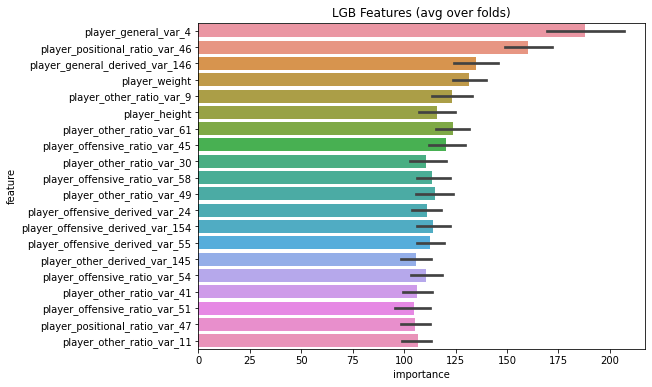

In [11]:
feature_importance["importance"] /= 10
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:20].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(8, 6))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LGB Features (avg over folds)')

In [12]:
sub['rating_num'] = test_preds
sub.to_csv('lgb61.csv', index = False)